In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from tensorflow.keras import layers, losses, optimizers
import joblib

import matplotlib.dates as mdates
import datetime

import pickle


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 0. Download data

In [36]:


# Download data
data = yf.download("^GSPC", start="2015-05-23", end="2023-05-23")
data.reset_index(inplace=True)
data.set_index("Date", inplace=True)


[*********************100%***********************]  1 of 1 completed


In [37]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-26,2125.340088,2125.340088,2099.179932,2104.199951,2104.199951,3342130000
2015-05-27,2105.129883,2126.219971,2105.129883,2123.479980,2123.479980,3127960000
2015-05-28,2122.270020,2122.270020,2112.860107,2120.790039,2120.790039,2980350000


In [38]:
# Get date and close colums from data
df = data.loc[:, ["Close"]]


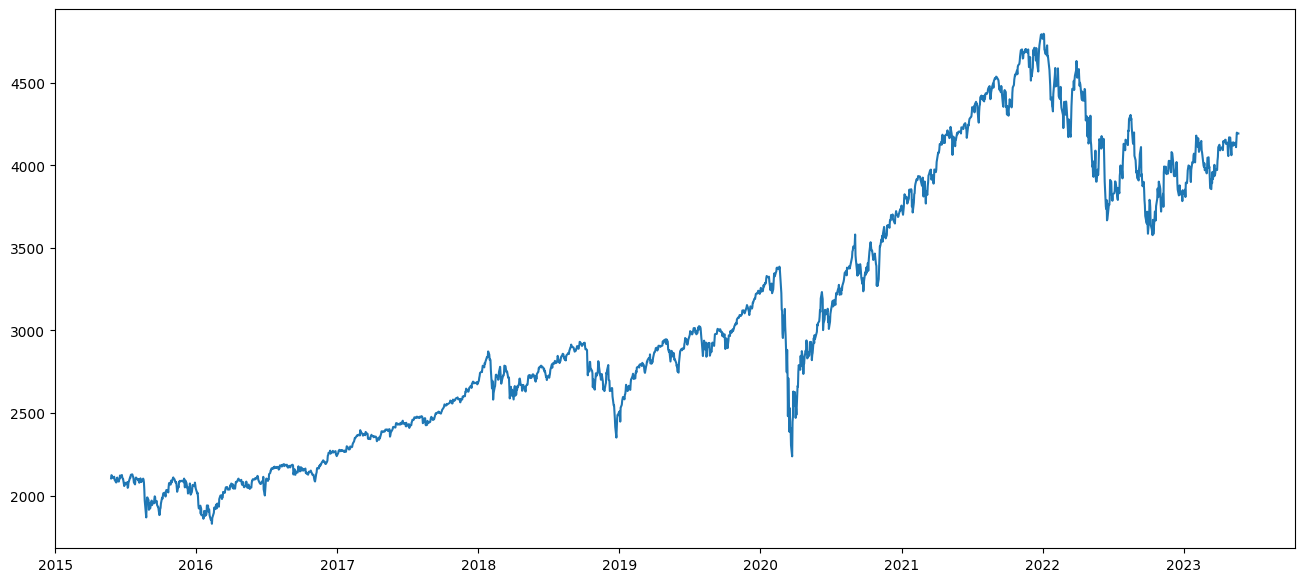

In [39]:
plt.figure(figsize=(16,7))

plt.plot(data.loc[:, "Close"])

In [40]:
df.shape

(2013, 1)

In [41]:
df["Close"]

Date
2015-05-26    2104.199951
2015-05-27    2123.479980
2015-05-28    2120.790039
2015-05-29    2107.389893
2015-06-01    2111.729980
                 ...     
2023-05-16    4109.899902
2023-05-17    4158.770020
2023-05-18    4198.049805
2023-05-19    4191.979980
2023-05-22    4192.629883
Name: Close, Length: 2013, dtype: float64

### 2. Lag data

In [42]:
# Lag data
def lag_transform(x, k=1):
    lagged = np.concatenate([np.repeat(np.nan, k), x[:len(x)-k]])
    df = pd.DataFrame({'x-'+str(k): lagged, 'x': x})
    df.fillna(0, inplace=True)
    return df

In [43]:
df=lag_transform(df["Close"],1)

In [44]:
df= df.rename(columns={"x-1": "x","x":"y"})


In [45]:
df.head(5)

,x,y
Date,,
2015-05-26,0.000000,2104.199951
2015-05-27,2104.199951,2123.479980
2015-05-28,2123.479980,2120.790039
2015-05-29,2120.790039,2107.389893
2015-06-01,2107.389893,2111.729980


In [46]:
# Split data 
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)


In [47]:
train_data.shape

(1610, 2)

In [48]:
test_data.shape

(403, 2)

In [49]:
train_predictor = train_data["x"]
train_target=train_data["y"]
test_predictor=test_data["x"]
test_target=test_data["y"]

In [50]:
train_predictor

Date
2015-05-26       0.000000
2015-05-27    2104.199951
2015-05-28    2123.479980
2015-05-29    2120.790039
2015-06-01    2107.389893
                 ...     
2021-10-07    4363.549805
2021-10-08    4399.759766
2021-10-11    4391.339844
2021-10-12    4361.189941
2021-10-13    4350.649902
Name: x, Length: 1610, dtype: float64

### 4. Reshape data to windown size =5 and timestep=1

In [51]:
# Reshape input data [batch size, timestep, feature=1] and output
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)



In [52]:
train_predictor, train_target = dataset_generator_lstm(train_data.values,look_back=5)

test_predictor, test_target = dataset_generator_lstm(test_data.values,look_back=5)

print("trainX: ", train_predictor.shape)
print("trainY: ", train_target.shape)
print("testX: ", test_predictor.shape)
print("testY", test_target.shape)

trainX:  (1605, 5)
trainY:  (1605,)
testX:  (398, 5)
testY (398,)


### 5. Grid Search CV

In [53]:
train_predictor_reshape = np.reshape(train_predictor ,(train_predictor.shape[0], 5, 1))
#train_target_reshape = np.reshape(train_target, (train_target.shape[0], 2, 1))
test_predictor_reshape=np.reshape(test_predictor, (test_predictor.shape[0], 5, 1))
#test_target_reshape=np.reshape(test_target.values, (batch_size, time_steps, 1))

In [54]:
patience = 10  # Number of epochs with no improvement after which training will be stopped
monitor = 'val_loss'  # Metric to monitor for early stopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

In [159]:
# Define a function to create the LSTM model
def LSTM_model(neurons_per_layer, activation='relu', optimizer='adam', dropout=0.0, num_layers=1, time_steps=5,batch_size=2):
    
    model = Sequential()
    if num_layers == 1:
        model.add(LSTM(units=neurons_per_layer, activation=activation, batch_input_shape=(batch_size,time_steps, 1)))
    else:
        model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True,  batch_input_shape=(batch_size,time_steps, 1)))
        for i in range(num_layers-2):
            model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True))
        model.add(LSTM(units=neurons_per_layer, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model


# Create a KerasRegressor object with the create_model function
model = KerasRegressor(build_fn=LSTM_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'neurons_per_layer': [32,50,100],
    'num_layers': [1, 2,3],
    'batch_size': [4,16,32],
    'dropout': [0.0, 0.1,0.2],
}
# Create a GridSearchCV object with the model and hyperparameter grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,scoring="neg_mean_absolute_error")

# Reshape the data for each combination of batch_size and time_steps
#for batch_size in param_grid['batch_size']:
    #for time_steps in param_grid['time_steps']:

start_time = time.time()

grid.fit(train_predictor_reshape, train_target,validation_data=(test_predictor_reshape,test_target),
                            epochs=150,callbacks=[early_stopping],verbose=0)

end_time = time.time()

# Print the best set of hyperparameters
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: ", end_time - start_time, " seconds")



In [ ]:
grid_loaded = joblib.load('grid_search.pkl')


In [ ]:
#cv_results = grid_loaded .cv_results_
#for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    #print(mean_score, params)

-720.3122660105101 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 32, 'num_layers': 1}
-31.6903502086984 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 32, 'num_layers': 2}
-35.76510043990947 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 32, 'num_layers': 3}
-24.560288740021416 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 50, 'num_layers': 1}
-36.27916141878408 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 50, 'num_layers': 2}
-37.32647952261001 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 50, 'num_layers': 3}
-27.222341833382007 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 100, 'num_layers': 1}
-28.463981195847936 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 100, 'num_layers': 2}
-35.016040419343845 {'batch_size': 4, 'dropout': 0.0, 'neurons_per_layer': 100, 'num_layers': 3}
-171.09787704135024 {'batch_size': 4, 'dropout': 0.1, 'neurons_per_layer': 32, 'num_layers': 1}
-172.8255141403816 {'batch_size': 4, 'dropo

In [ ]:
best_model = grid_loaded .best_estimator_.model


In [57]:
LSTM_model = tf.keras.Sequential([
    layers.LSTM(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="LSTM_model")


In [58]:
LSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])

In [ ]:
#history_lstm = LSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=150, callbacks=[early_stopping])

Epoch 1/500
402/402 [==============================] - 1s 2ms/step - loss: 25.2210 - mae: 25.2210 - val_loss: 56.8189 - val_mae: 56.8189
Epoch 2/500
402/402 [==============================] - 1s 2ms/step - loss: 24.9960 - mae: 24.9960 - val_loss: 59.4641 - val_mae: 59.4641
Epoch 3/500
402/402 [==============================] - 1s 2ms/step - loss: 25.0340 - mae: 25.0340 - val_loss: 56.0197 - val_mae: 56.0197
Epoch 4/500
402/402 [==============================] - 1s 2ms/step - loss: 25.2865 - mae: 25.2865 - val_loss: 55.1777 - val_mae: 55.1777
Epoch 5/500
402/402 [==============================] - 1s 2ms/step - loss: 25.2921 - mae: 25.2921 - val_loss: 57.6604 - val_mae: 57.6604
Epoch 6/500
402/402 [==============================] - 1s 2ms/step - loss: 25.5778 - mae: 25.5778 - val_loss: 54.7474 - val_mae: 54.7474
Epoch 7/500
402/402 [==============================] - 1s 2ms/step - loss: 25.2222 - mae: 25.2222 - val_loss: 54.8760 - val_mae: 54.8760
Epoch 8/500
402/402 [====================

In [59]:

# Load the saved history object from a file
with open('history_lstm.pkl', 'rb') as file:
    history_lstm = pickle.load(file)


In [60]:
LSTM_model.load_weights("./Modelfit/LSTM")

In [61]:
lossLSTM,maeLSTM= LSTM_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 50.5501 - mae: 50.5501


In [62]:
lossLSTMtrain,maeLSTMtrain= LSTM_model.evaluate(train_predictor_reshape,train_target)

51/51 [==============================] - 0s 1ms/step - loss: 22.3237 - mae: 22.3237


In [63]:
test_target_pred = LSTM_model.predict(test_predictor_reshape)
train_target_pred=LSTM_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [119]:
loss_values_LSTM = []
for i in range(len(test_target)):
    loss = LSTM_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    loss_values_LSTM.append(loss)


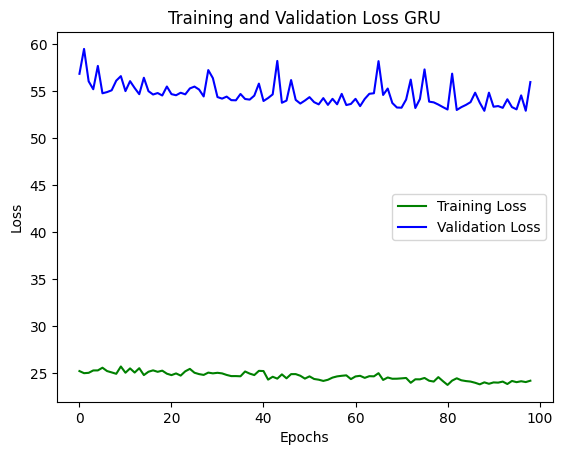

In [64]:
accuracy_train_LSTM = history_lstm.history['loss']
accuracy_val_LSTM = history_lstm.history['val_loss']
epochs = range(0, 99)

plt.plot(epochs, accuracy_train_LSTM, 'g', label='Training Loss')
plt.plot(epochs, accuracy_val_LSTM, 'b', label='Validation Loss')
plt.title('Training and Validation Loss GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


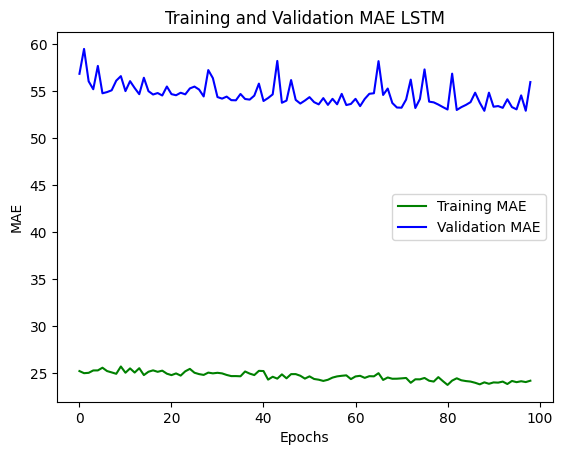

In [65]:
mae_train_LSTM = history_lstm.history['mae']
mae_val_LSTM = history_lstm.history['val_mae']
epochs = range(0,99)

plt.plot(epochs, mae_train_LSTM, 'g', label='Training MAE')
plt.plot(epochs, mae_val_LSTM, 'b', label='Validation MAE')
plt.title('Training and Validation MAE LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### 6. Plot

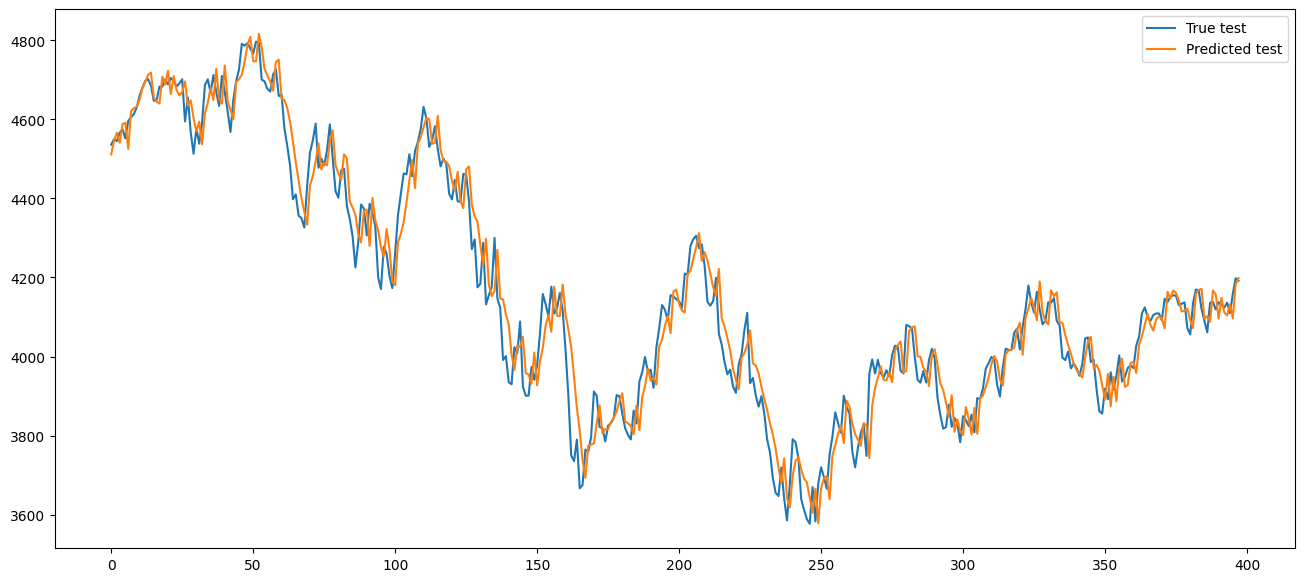

In [66]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test')
plt.plot(test_target_pred, label='Predicted test')


plt.legend()
plt.show()

In [67]:
mae_lstm_test = mean_absolute_error(test_target, test_target_pred)
print('Test MAE: %.3f' % mae_lstm_test)



Test MAE: 50.550


In [68]:
mae_lstm_train = mean_absolute_error(train_target, train_target_pred)
print('Train MAE: %.3f' % mae_lstm_train)




Train MAE: 22.324


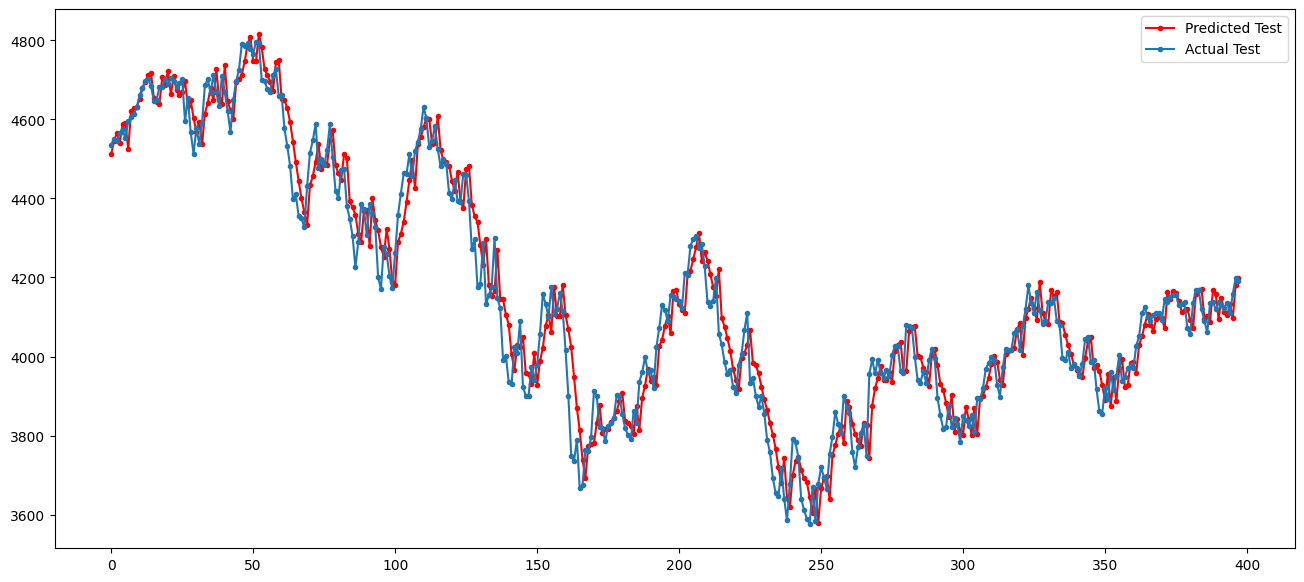

In [69]:
plt.figure(figsize=(16,7))

plt.plot(test_target_pred, 'r', marker='.', label='Predicted Test')

plt.plot(test_target, marker='.', label='Actual Test')

plt.legend()
plt.show()

### 2. GRU

In [70]:
GRU_model = tf.keras.Sequential([
    layers.GRU(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="GRU_model")
GRU_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])


In [ ]:
#history_gru = GRU_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=150, callbacks=[early_stopping])

In [71]:
GRU_model.load_weights("./Modelfit/GRU")

In [72]:
lossGRU,maeGRU=GRU_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 51.4286 - mae: 51.4286


In [73]:
test_target_pred_gru = GRU_model.predict(test_predictor_reshape)
train_target_pred_gru=GRU_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [118]:
loss_values_GRU = []
for i in range(len(test_target)):
    loss = GRU_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    loss_values_GRU.append(loss)


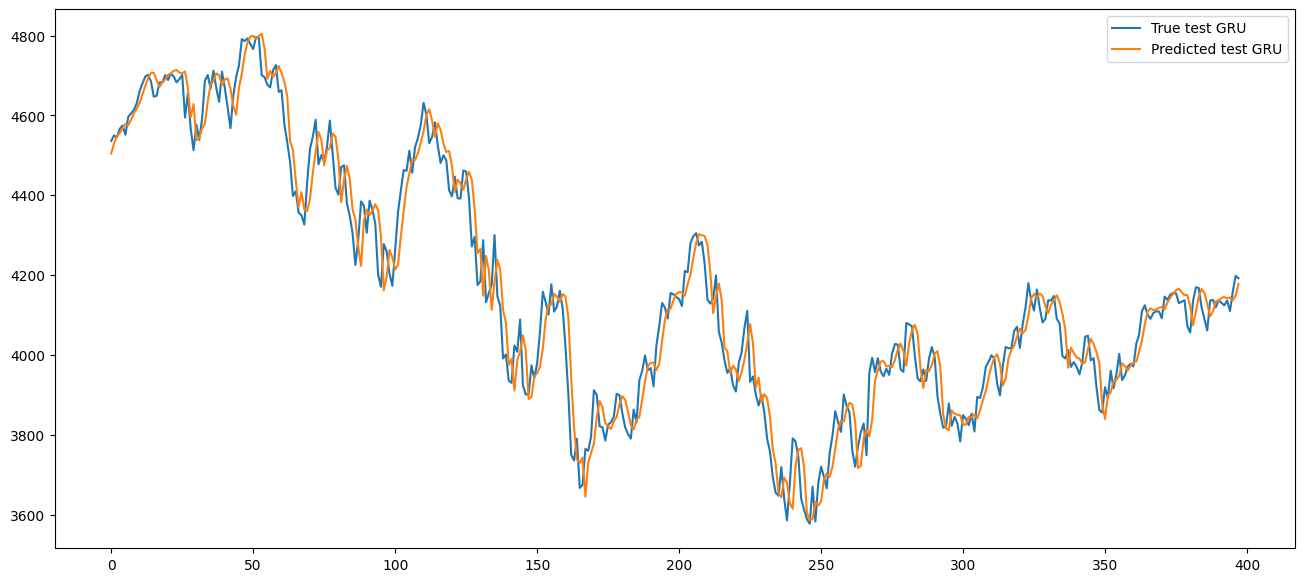

In [74]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test GRU')
plt.plot(test_target_pred_gru, label='Predicted test GRU')

plt.legend()
plt.show()

### 3. RNN

In [75]:
RNN_model = tf.keras.Sequential([
    layers.SimpleRNN(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="RNN_model")
RNN_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])

In [47]:

#history_RNN = RNN_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=500, callbacks=[early_stopping])

Epoch 1/500
402/402 [==============================] - 1s 2ms/step - loss: 778.7864 - mae: 778.7864 - val_loss: 90.3043 - val_mae: 90.3043
Epoch 2/500
402/402 [==============================] - 1s 1ms/step - loss: 39.0866 - mae: 39.0866 - val_loss: 81.6333 - val_mae: 81.6333
Epoch 3/500
402/402 [==============================] - 1s 1ms/step - loss: 39.9385 - mae: 39.9385 - val_loss: 81.4925 - val_mae: 81.4925
Epoch 4/500
402/402 [==============================] - 1s 1ms/step - loss: 39.2878 - mae: 39.2878 - val_loss: 78.2668 - val_mae: 78.2668
Epoch 5/500
402/402 [==============================] - 1s 1ms/step - loss: 39.0261 - mae: 39.0261 - val_loss: 76.8113 - val_mae: 76.8113
Epoch 6/500
402/402 [==============================] - 1s 1ms/step - loss: 37.7124 - mae: 37.7124 - val_loss: 81.2484 - val_mae: 81.2484
Epoch 7/500
402/402 [==============================] - 1s 1ms/step - loss: 37.0369 - mae: 37.0369 - val_loss: 74.9709 - val_mae: 74.9709
Epoch 8/500
402/402 [==================

In [76]:
RNN_model.load_weights("./Modelfit/RNN")

In [77]:
lossRNN,maeRNN=RNN_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 44.5153 - mae: 44.5153


In [86]:
test_target_pred_rnn = RNN_model.predict(test_predictor_reshape)
train_target_pred_rnn=RNN_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 918us/step


In [106]:
loss_values_RNN = []
for i in range(len(test_target)):
    loss = RNN_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    loss_values_RNN.append(loss)


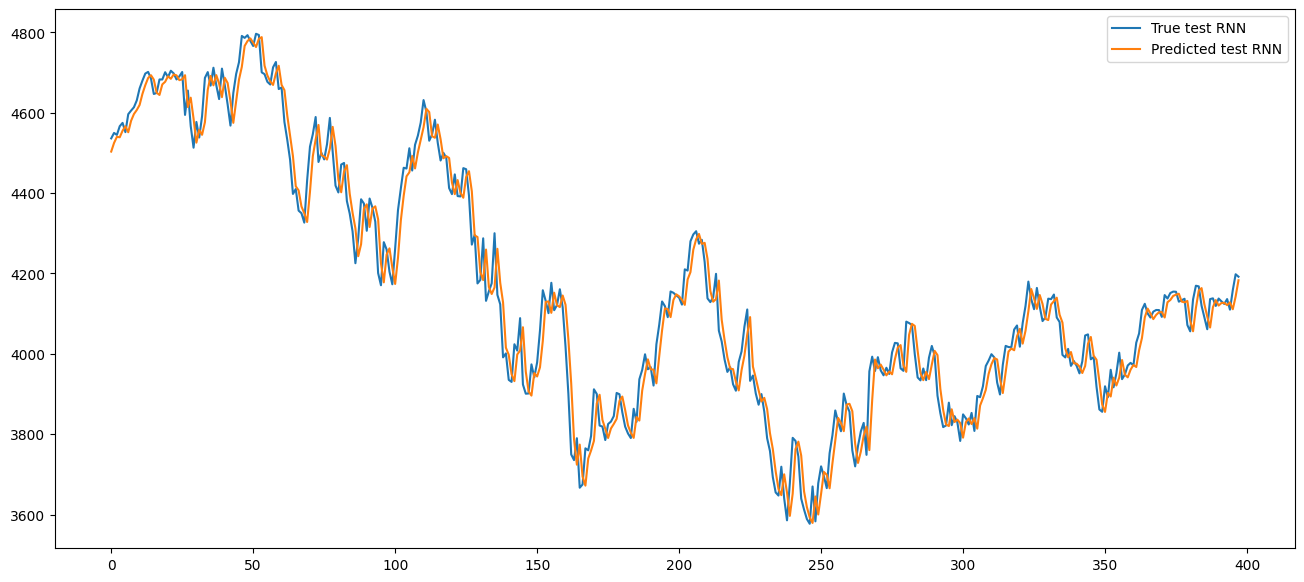

In [87]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test RNN')
plt.plot(test_target_pred_rnn, label='Predicted test RNN')

plt.legend()
plt.show()

### 4. BiLSTM

In [81]:
BiLSTM_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(50, activation='relu', batch_input_shape=(4, 5, 1))),
    layers.Dense(1)
], name="BiLSTM_model")
BiLSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])



In [53]:
#history_BiLSTM = BiLSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=500, callbacks=[early_stopping])

Epoch 1/500
402/402 [==============================] - 3s 3ms/step - loss: 1011.1199 - mae: 1011.1199 - val_loss: 62.0361 - val_mae: 62.0361
Epoch 2/500
402/402 [==============================] - 1s 2ms/step - loss: 32.4677 - mae: 32.4677 - val_loss: 67.1301 - val_mae: 67.1301
Epoch 3/500
402/402 [==============================] - 1s 2ms/step - loss: 31.5878 - mae: 31.5878 - val_loss: 61.9138 - val_mae: 61.9138
Epoch 4/500
402/402 [==============================] - 1s 2ms/step - loss: 30.8511 - mae: 30.8511 - val_loss: 62.3409 - val_mae: 62.3409
Epoch 5/500
402/402 [==============================] - 1s 2ms/step - loss: 30.1885 - mae: 30.1885 - val_loss: 61.6506 - val_mae: 61.6506
Epoch 6/500
402/402 [==============================] - 1s 2ms/step - loss: 33.6243 - mae: 33.6243 - val_loss: 62.1758 - val_mae: 62.1758
Epoch 7/500
402/402 [==============================] - 1s 2ms/step - loss: 29.2461 - mae: 29.2461 - val_loss: 61.9438 - val_mae: 61.9438
Epoch 8/500
402/402 [================

In [82]:
BiLSTM_model.load_weights("./Modelfit/BiLSTM")

In [83]:
lossBiLSTM,maeBiLSTM=BiLSTM_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 1s 2ms/step - loss: 57.7497 - mae: 57.7497


In [84]:
test_target_pred_BiLSTM = BiLSTM_model.predict(test_predictor_reshape)
train_target_pred_NiLSTM=BiLSTM_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


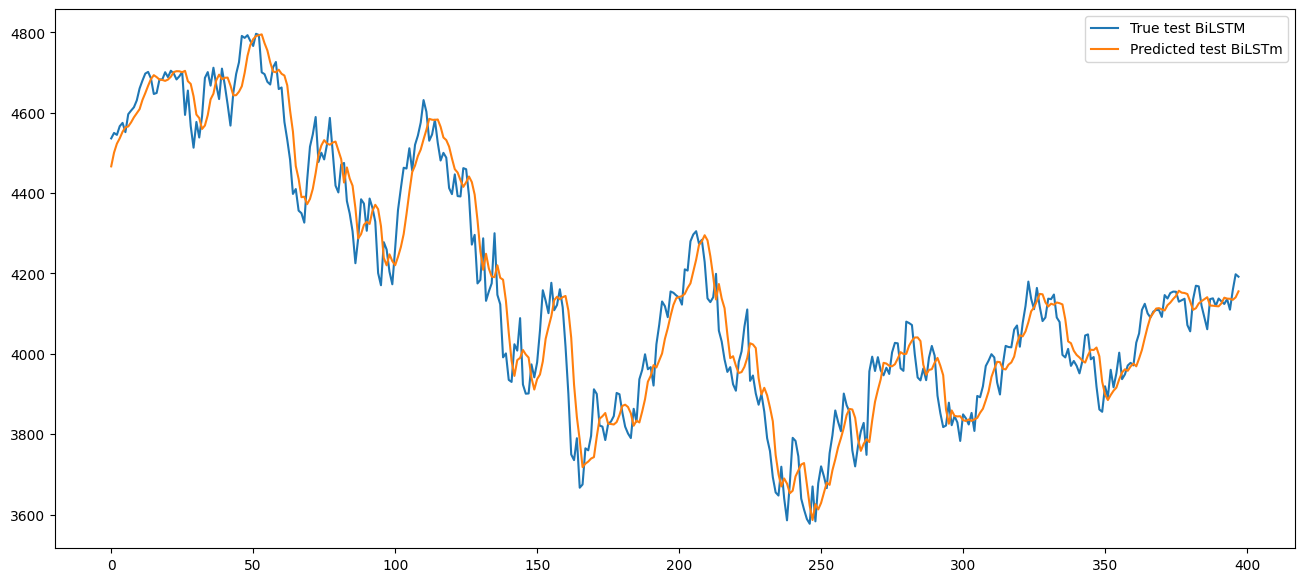

In [85]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test BiLSTM')
plt.plot(test_target_pred_BiLSTM, label='Predicted test BiLSTm')

plt.legend()
plt.show()

### Extract each loss per predictor

In [104]:
test_target_pred_BiLSTM[0]

array([4466.5864], dtype=float32)

In [105]:
test_target[0]

4536.18994140625

In [99]:
loss_values_BiLSTM = []
for i in range(len(test_target)):
    loss = BiLSTM_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    loss_values_BiLSTM.append(loss)


In [103]:
loss_values_BiLSTM

[69.603515625,
 48.95751953125,
 21.91552734375,
 30.11083984375,
 22.154296875,
 12.01953125,
 30.4970703125,
 29.255859375,
 24.98681640625,
 31.869140625,
 51.54150390625,
 48.2958984375,
 48.63720703125,
 34.47998046875,
 1.3125,
 46.84375,
 39.47021484375,
 0.33349609375,
 1.15234375,
 21.5498046875,
 6.00244140625,
 14.9638671875,
 3.18212890625,
 20.55078125,
 12.51318359375,
 0.49609375,
 109.7080078125,
 23.3115234375,
 104.751953125,
 127.97509765625,
 18.4345703125,
 48.41796875,
 32.01806640625,
 118.50244140625,
 107.12060546875,
 34.06201171875,
 64.580078125,
 11.83984375,
 60.81298828125,
 26.26611328125,
 18.408203125,
 66.84912109375,
 99.791015625,
 5.8642578125,
 52.87353515625,
 73.33203125,
 125.1884765625,
 86.9296875,
 51.53076171875,
 9.5966796875,
 16.93212890625,
 5.59130859375,
 0.45263671875,
 94.490234375,
 77.03564453125,
 78.07568359375,
 55.37158203125,
 10.2236328125,
 25.63916015625,
 48.11865234375,
 34.10302734375,
 115.50048828125,
 135.416015625,


In [101]:
len(loss_values_BiLSTM)

398

In [102]:
len(test_target)

398

### 3. ARIMA

### Model performance

In [56]:

print("MAE of RNN on test set: ", maeRNN)
print("MAE of LSTM on test set: ", maeLSTM)
print("MAE of BiBLSTM on test set: ", maeBiLSTM)
print("MAE of GRU on test set: ", maeGRU)



MAE of RNN on test set:  44.51530075073242
MAE of LSTM on test set:  50.550148010253906
MAE of BiBLSTM on test set:  57.74971008300781
MAE of GRU on test set:  51.42856216430664


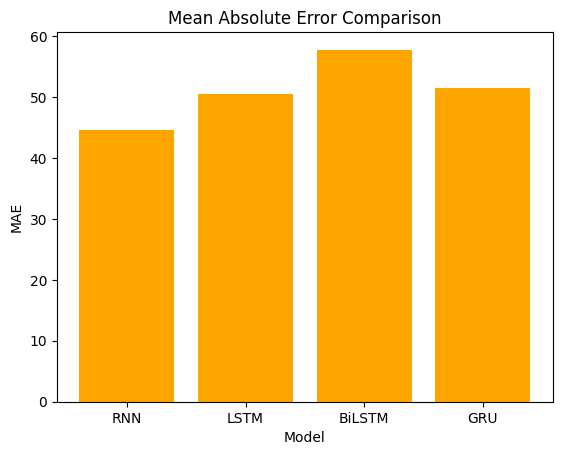

In [58]:

# Define the model names and their respective MAE values
model_names = ['RNN', 'LSTM', 'BiLSTM', 'GRU']
mae_values = [maeRNN, maeLSTM, maeBiLSTM, maeGRU]

# Create the bar plot with orange color
plt.bar(model_names, mae_values, color='orange')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Comparison')
plt.show()


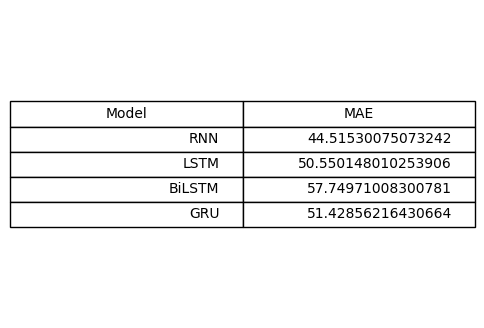

In [96]:

# Create the table of values
table_values = [[model_names[i], mae_values[i]] for i in range(len(model_names))]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Hide the axis
ax.axis('off')

# Create the table
table = ax.table(cellText=table_values, colLabels=['Model', 'MAE'], loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.show()


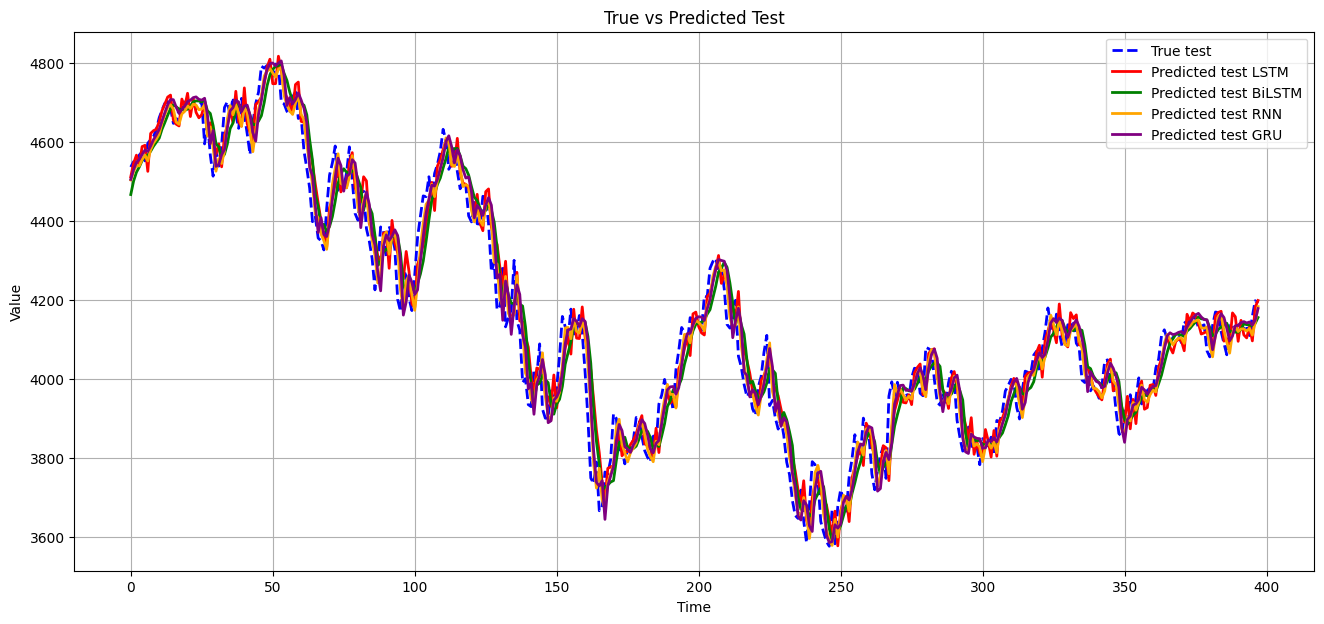

In [91]:

plt.figure(figsize=(16,7))

# Plot the lines with different colors and line styles
plt.plot(test_target, label='True test', color='blue', linestyle='--', linewidth=2)
plt.plot(test_target_pred, label='Predicted test LSTM', color='red', linestyle='-', linewidth=2)
plt.plot(test_target_pred_BiLSTM, label='Predicted test BiLSTM', color='green', linestyle='-', linewidth=2)
plt.plot(test_target_pred_rnn, label='Predicted test RNN', color='orange', linestyle='-', linewidth=2)
plt.plot(test_target_pred_gru, label='Predicted test GRU', color='purple', linestyle='-', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted Test')
plt.legend()
plt.grid(True)
plt.show()


### GW test

In [108]:
time_step=1
m = 5 #m:window size
T= len(test_predictor)
n= T-m-time_step_ahead+1


In [120]:
Z_m = 0
for i in range(T):
    Z_m += loss_values_GRU[i] - loss_values_LSTM[i]


In [113]:
Z_m

5267.284912109375

In [121]:
test_stat = n * ((1/n) * Z_m) * Z_m ** 2 * ((1/n) * Z_m)


In [122]:
test_stat

38896350.644017264

In [117]:
from scipy.stats import chi2

# Degrees of freedom
df = 1

# Significance level
alpha = 0.05

# Obtain critical value
critical_value = chi2.ppf(1 - alpha, df)

print("Critical value:", critical_value)


Critical value: 3.841458820694124
